# TP : Application de la découverte de motifs pour l’analyse de parties de Tennis de Table

#### Louis-Maël Gueguen (p2006947), Bertrand Huguenin-Bizot (p2019360), Tommaso Barberis (p1708628), Amélie Lafont (p2017902), Marie Verneret (p1609009)

## Introduction 

Le but de ce TP est d'appliquer différents algorithmes de recherche de motifs afin d'analyser un fichier décrivant une partie de Tennis de Table où les échanges ont été annotés. 
Malheureusement, la personne qui a complété ce fichier a changé certaines notations en cours de route, a décalé certaines lignes ou a omis de remplir certaines cellules. 
Le jeu de données a donc été modifié à la main (en utilisant un logiciel tableur) afin de l'homogénéiser et de le rendre exploitable.  

Nous avons choisi d'orienter notre approche de sorte à comprendre quelles sont les meilleures combinaisons utilisées par les deux joueurs pour marquer un point. 
Trois stratégies différentes ont été adoptées :
- Influence du service sur le marquage des points (__pysubgroup__)
- Combinaison d'attributs qui mène à un point (__pysubgroup__ et __exceptional model mining__ - __EMM__)
- Stratégie adoptée par les joueurs (__mlxtend__)

## 1 Influence du service (pysubgroup)

In [4]:
import pysubgroup as ps
import pandas as pd

In [5]:
#importation du jeu de données
data=pd.read_csv("TT_game.csv", sep=';')

### Reformatage des données

Comme nous souhaitons analyser si le service donne un avantage pour marquer un point, il est important de produire un dataframe dans lequel une ligne correspond à un point. Il a donc été nécessaire de reformater les données en gardant uniquement les colonnes d'intérêt et en regroupant les informations d'un échange en une ligne. Pour cela, nous avons supprimé toutes les lignes pour lequelles nous n'avions pas d'information sur les types de services et les zones de jeu. Ainsi les lignes correspondant au service et au marquage d'un point sont conservées. 

In [6]:
###Reformatage des données (on ne garde que les colonnes qui nous intéressent)
data = data[['Nom', 'Coup', 'Score', 'Type de service', 'Type Coup TK', 'Zone de jeu']]

#Pour faire une ligne par échange, on ne garde que les services et les coups gagnants
list_ind = []
for ind in data.index:
    #retirer la ligne de services ratés
    if str(data['Type de service'][ind])!='nan' and (str(data['Zone de jeu'][ind])=='nan'):
        list_ind.append(ind)
    #retirer les lignes entre le service et le score
    elif str(data['Score'][ind])=="nan" and (str(data['Type de service'][ind])=='nan'):
        list_ind.append(ind)
data = data.drop(list_ind)
data = data.reset_index(drop=True)

#suppression de la colonne score
data = data.drop(columns = ['Score'])
data = data.reset_index(drop=True)
#pd.set_option('display.max_rows', None)
data

,Nom,Coup,Type de service,Type Coup TK,Zone de jeu
0,F.T. (1),F.T.,Latéral droit,NaN,M2
1,F.T. (4),Serveur Point -,NaN,Controle / Résistance,NaN
2,F.T. (5),F.T.,Latéral droit,NaN,M2
3,F.T. (7),Serveur Point -,NaN,Attaque / Offensif,NaN
4,B.T. (6),B.T.,Latéral gauche,NaN,G21
...,...,...,...,...,...
209,F.T. (255),Serveur Point +,NaN,Attaque / Offensif,NaN
210,F.T. (257),F.T.,Latéral droit,NaN,M2
211,F.T. (258),Serveur Point -,NaN,Controle / Résistance,NaN
212,F.T. (259),F.T.,Latéral droit,NaN,M1


Pour pouvoir utiliser l'algorithme, la dernière étape a été de fusionner les deux lignes de service et de marquage de point. Pour cela, nous avons créé une nouvelle colonne appelée `Victory` qui indique si la personne qui a fait le service a marqué le point ou pas.

In [7]:
#creation de la table définitive avec une ligne par point
list_ind = []
victory = []
for ind in data.index:
    if (str(data['Zone de jeu'][ind])=='nan'):
        data['Type Coup TK'][ind-1] = str(data['Type Coup TK'][ind])
        list_ind.append(ind)
        if str(data['Coup'][ind]).endswith('-'):
            victory.append(0)
        elif str(data['Coup'][ind]).endswith('+'):
            victory.append(1)
data = data.drop(list_ind)
data = data.reset_index(drop=True)
#data = data.drop(columns=['Nom'])
data = data.drop(columns=['Nom', 'Coup'])
data['Victory'] = victory
data

,Type de service,Type Coup TK,Zone de jeu,Victory
0,Latéral droit,Controle / Résistance,M2,0
1,Latéral droit,Attaque / Offensif,M2,0
2,Latéral gauche,Controle / Résistance,G21,0
3,Latéral droit,Controle / Résistance,M1,0
4,Latéral droit,Controle / Résistance,M2,0
...,...,...,...,...
102,Latéral droit,Attaque / Offensif,G1,1
103,Latéral droit,Attaque / Offensif,D1,1
104,Latéral droit,Attaque / Offensif,G21,1
105,Latéral droit,Controle / Résistance,M2,0


### Execution de Pysubgroup

Cet algorithme va rechercher des sous-groupe à partir d'une target donnée. Dans notre cas, la target constitue la colonne de victoire. La recherche de sous-groupe est alors effectuée dans les autres colonnes (type de service, type de coup lors du service et zone de jeu pour le service).

In [17]:
#execution du langage pysubgroup en choisissant la colonne victory comme target 
target = ps.BinaryTarget ('Victory', True)
searchspace = ps.create_selectors(data, ignore=['Victory'])
task = ps.SubgroupDiscoveryTask (
    data, 
    target, 
    searchspace, 
    result_set_size=9, 
    depth=2, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)
result = result.to_dataframe()
for ind in result.index:
    print(result['quality'][ind], result['subgroup'][ind])

0.029434885142807246 Type de service=='Latéral droit' AND Zone de jeu=='M1'
0.027600663813433502 Zone de jeu=='M1'
0.021835968206830293 Zone de jeu=='G3'
0.017468774565464234 Type de service=='Latéral gauche' AND Zone de jeu=='G3'
0.01685736745567299 Type Coup TK=='Poussette' AND Zone de jeu=='M1'
0.01624596034588174 Type Coup TK=='Poussette' AND Type de service=='Latéral droit'
0.01624596034588174 Type Coup TK=='Poussette'
0.013101580924098176 Type Coup TK=='Controle / Résistance' AND Type de service=='Unknown'
0.013101580924098176 Type Coup TK=='Controle / Résistance' AND Zone de jeu=='G3'


C:\Users\marie\AppData\Local\Temp/ipykernel_11928/3690221061.py:12: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  result = result.to_dataframe()


Les résultats de pysubgroup montrent que les services `lateral droit` dans la zone de jeu M1 sont plus propices pour marquer un point. Le type de service et la zone de jeu semblent plus influencer le score que le type de coup, ce dernier n'apparaissant qu'en cinquième position dans la liste des résultats. De manière générale, c'est dans les zones `M1` et `G3` que les services sont les plus efficaces correspondant respectivement au centre de la table proche du filet et au coin extérieur gauche de l'adversaire.

## 2. Combinaison d'attributs qui mène à un point (EMM)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './emm')
import EMM as emm

In [2]:
# import data
data = pd.read_csv("TT_game.csv", sep = ";",
                   dtype={
                          "Nom": str,
                          "Position": str,
                          "Durée": str,
                          "Genre": str,
                          "Latéralité": str,
                          "Set": str,
                          "Système": str,
                          "Coup": str,
                          "Nbre de coups par point": np.float64,
                          "Durée du point": str,
                          "Score": str,
                          "Points F": np.float64,
                          "Points B": np.float64,
                          "Type de service": str,
                          "Type Coup TK": str,
                          "Zone de jeu": str
})

### Reformatage des données

#### Description de la fonction permettant de formater les données `df_player`

Cette fonction permet de construire un tableau pour un joueur donné, où chaque ligne correspond à un point joué. Pour chaque point seront detaillés les attributs suivant:
- la __durée__ du point selon un intervalle (si le point a été de: __courte__, __moyenne__ ou __longue__ durée) $\Rightarrow$ colonne <u>Duree</u>;
- nb de __coups droits__ du jouer selectionné lors du point $\Rightarrow$ colonne <u>coup_droit_player_1</u>:
    - de même pour l'autre joueur <u>coup_droit_player_2</u>;
- nb de coups __revers__ du joueur selectionné lors du point $\Rightarrow$ colonne <u>revers_player_1</u>:
    - de même pour l'autre joueur <u>revers_player_2</u>;
- nb de __coups effectués__ (par l'ensemble des joueurs) $\Rightarrow$ colonne <u>Nb_coups</u>;
- numéro du __set__ dans lequel le point est joué (au total 5 set) $\Rightarrow$ colonne <u>Set</u>;
- la __progression du set__, si après le point considéré, le joueur selectionné est en train de remporter ou pas le set ('__<__': s'il est en train de perdre le set, '__>__': s'il est en train de gagner le set, '__=__': si les deux joueur ont le même score) $\Rightarrow$ colonne <u>Gagnant_ou_pas</u>;
- qui a effectué le __service__ et de quel côté $\Rightarrow$ colonne <u>Service</u>;
- nb de fois que le joueur selectionné a joué en __controle__ $\Rightarrow$ colonne <u>controle_player_1</u>:
    - de même pour l'autre joueur, colonne <u>controle_player_2</u>;
- nb de fois que le joueur selectionné a joué en __attaque__ $\Rightarrow$ colonne <u>attaque_player_1</u>:
    - de même pour l'autre joueur, colonne <u>attaque_player_1</u>;
- nb de fois que le joueur selectionné a joué avec une __poussette__ $\Rightarrow$ colonne <u>poussette_player_1</u>:    
    - de même pour l'autre joueur, colonne <u>poussette_player_2</u>;
- nb de fois que le joueur __a envoyé__ la balle dans la zone __M1__ lors du point $\Rightarrow$ colonne <u>M1_envoie</u>:
    - de même pour les autres zones de jeu $\Rightarrow$ colonnes <u>M2_envoie</u>, <u>M3_envoie</u>, etc;
- nb de fois que le joueur __a reçu__ la balle dans la zone __M1__ lors du point $\Rightarrow$ colonne <u>M1_reception</u>:     
    - de même pour les autres zones de jeu $\Rightarrow$ colonnes <u>M2_reception</u>, <u>M3_reception</u>, etc;

In [3]:
# convert to deltatime
data['Position'] = pd.to_timedelta(data['Position'])
data['Durée'] = pd.to_timedelta(data['Durée'])

# convert deltatime format to float
data["Position"] = (data["Position"] / np.timedelta64(10**9,'ns')).astype(float)
data["Durée"] = (data["Durée"] / np.timedelta64(10**9,'ns')).astype(float)

# clean "Set" column
for index, row in data.iterrows():
    val = row["Nom"]
    if val.startswith("SET"):
        set_nb = val.split("(")[1][:1]
    data.at[index, "Set"] = set_nb   

# compute the number of hits for each point
c = 0
for index, row in data.iterrows():
    if (row["Coup"] != "F.T.") and (row["Coup"] != "B.T."):
        c = 0
        data.at[index, "Nbre de coups par point"] = c
    else:
        c += 1
        data.at[index, "Nbre de coups par point"] = c
data["Nbre de coups par point"] = pd.to_numeric(data["Nbre de coups par point"]).astype(int)  

# columns for the new dataframe    
columns = ["Duree", "coup_droit_player_1", "coup_droit_player_2", "revers_player_1", "revers_player_2", "Nb_coups", "Set", \
           "Gagnant_ou_pas", "Service", "controle_player_1", "controle_player_2", "attaque_player_1", "attaque_player_2", \
           "poussette_player_1", "poussette_player_2", "M1_envoie", "M1_reception", "M2_envoie", "M2_reception", \
           "M3_envoie", "M3_reception","D1_envoie", "D1_reception", "D2_envoie", "D2_reception", "D3_envoie",\
           "D3_reception", "G1_envoie", "G1_reception", "G2_envoie", "G2_reception", "G3_envoie", \
           "G3_reception", "Gagnant"] 

def pts_time(point):
    """
    Return the elapsed time for the point.
    """
    time = 0.000
    for index, row in point.iterrows():
        if index != 0:
            time += row["Durée"]
    return time

def class_time(time, quantiles):
    """
    Define the time of the point as class.
    """
    if time < quantiles[0]:
        return "short"
    elif time >= quantiles[0] and time <= quantiles[2]:
        return "middle"
    elif time > quantiles[2]:
        return "long"
    
def pts_score(point, player):
    """
    Return a string that define the player that is winning the set.
    '<': player F.T. is winning
    '>': player B.T. is winning
    '=': draw
    """
    if player == "F":
        score_player1 = int(point.iloc[-1]["Points F"])
        score_player2 = int(point.iloc[-1]["Points B"])
    else:
        score_player1 = int(point.iloc[-1]["Points B"])
        score_player2 = int(point.iloc[-1]["Points F"])
        
    if score_player1 < score_player2:
        return "<"
    elif score_player1 > score_player2:
        return ">"
    else:
        return "="
    
def pts_service(point, player):
    """
    Return a string that decode who did the service and the side
    """
    service = point[point["Type de service"].notna()]["Type de service"].tolist()
    try:
        # if a net is done, it keeps only the last service
        if service[-1] == "Serveur Point - 8-4+I216:I223":
            service = service[-2]
        else:
            service = service[-1]
    except:
        service = np.nan # if double fault
    player_c =  point[point["Coup"].notna()]["Coup"].tolist()[0]
    if player == player_c[0]:
        player = "player1"
    else:
        player = "player2"
    service = str(player) + " - " + str(service)
    return service

def point_winner(point, player): 
    """
    Define if the player has won the point or not. Return a boolean.
    """
    win = point.iloc[-1]["Coup"]
    service = pts_service(point, player)
    has_service = service.split(" ")[0] # get the player that have done the service

    if (has_service == "player1" and win.split(" ")[-1] == "-") or (has_service == "player2" and win.split(" ")[-1] == "+"):
        return "No"
    elif (has_service == "player1" and win.split(" ")[-1] == "+") or (has_service == "player2" and win.split(" ")[-1] == "-"):
        return "Yes"
    
def df_player(player, data):
    """
    Create a dataframe with stats for a given player.
    player: 'F' or 'B'
    data: dataframe
    """
    player_data = pd.DataFrame(columns=columns) # df initialisation
    
    if player == "F":
        player1 = "F.T."
        player2 = "B.T."
    elif player == "B":
        player1 = "B.T."
        player2 = "F.T." 
    
    # total number of pts
    nb_pts = data["Points F"].dropna()
    nb_pts = len(nb_pts)

    # indices of pts row in the original df
    pts_indices = list(data[data["Points F"].notna()].index)
    pts_indices = [x + 1 for x in pts_indices] # to match df index
    pts_indices.insert(0, 0)

    # vector with time for each point
    times = []                
    for i in range(0, len(pts_indices)):
        try:
            point = data[pts_indices[i]:pts_indices[i+1]] # extract info for one point
        except:
            break # last point analysed
        
        times.append(pts_time(point))
    quantiles = np.quantile(times, [0.25, 0.5, 0.75])
    
    for i in range(0, len(pts_indices)):
        try:
            point = data[pts_indices[i]:pts_indices[i+1]] # extract info for one point
        except:
            break # last point analysed
            
        coup_droit_player1 = len(point[(point["Latéralité"] == "Coup droit") & (point["Nom"].str.startswith(player1))])
        coup_droit_player2 = len(point[(point["Latéralité"] == "Coup droit") & (point["Nom"].str.startswith(player2))])
        revers_player1 = len(point[(point["Latéralité"] == "Revers") & (point["Nom"].str.startswith(player1))])
        revers_player2 = len(point[(point["Latéralité"] == "Revers") & (point["Nom"].str.startswith(player2))])
        time = class_time(times[i-1], quantiles)
        nb_hit = len(point)
        Set = point["Set"].unique()[0]
        score = pts_score(point, player) # if he is winning the set or not
        service = pts_service(point, player)
        controle_player1 = len(point[(point["Type Coup TK"] == "Controle / Résistance") & (point["Nom"].str.startswith(player1))])
        controle_player2 = len(point[(point["Type Coup TK"] == "Controle / Résistance") & (point["Nom"].str.startswith(player2))])
        attaque_player1 = len(point[(point["Type Coup TK"] == "Attaque / Offensif") & (point["Nom"].str.startswith(player1))])
        attaque_player2 = len(point[(point["Type Coup TK"] == "Attaque / Offensif") & (point["Nom"].str.startswith(player2))])
        poussette_player1 = len(point[(point["Type Coup TK"] == "Poussette") & (point["Nom"].str.startswith(player1))])
        poussette_player2 = len(point[(point["Type Coup TK"] == "Poussette") & (point["Nom"].str.startswith(player2))])
        M1_send = len(point[(point["Zone de jeu"] == "M1") & (point["Nom"].str.startswith(player2))])
        M1_reception = len(point[(point["Zone de jeu"] == "M1") & (point["Nom"].str.startswith(player1))])
        M2_send = len(point[(point["Zone de jeu"] == "M2") & (point["Nom"].str.startswith(player2))])
        M2_reception = len(point[(point["Zone de jeu"] == "M2") & (point["Nom"].str.startswith(player1))])
        M3_send = len(point[(point["Zone de jeu"] == "M3") & (point["Nom"].str.startswith(player2))])
        M3_reception = len(point[(point["Zone de jeu"] == "M3") & (point["Nom"].str.startswith(player1))])
        D1_send = len(point[(point["Zone de jeu"] == "D1") & (point["Nom"].str.startswith(player2))])
        D1_reception = len(point[(point["Zone de jeu"] == "D1") & (point["Nom"].str.startswith(player1))])
        D2_send = len(point[(point["Zone de jeu"] == "D2") & (point["Nom"].str.startswith(player2))])
        D2_reception = len(point[(point["Zone de jeu"] == "D2") & (point["Nom"].str.startswith(player1))])
        D3_send = len(point[(point["Zone de jeu"] == "D3") & (point["Nom"].str.startswith(player2))])
        D3_reception = len(point[(point["Zone de jeu"] == "D3") & (point["Nom"].str.startswith(player1))])    
        G1_send = len(point[(point["Zone de jeu"] == "G1") & (point["Nom"].str.startswith(player2))])
        G1_reception = len(point[(point["Zone de jeu"] == "G1") & (point["Nom"].str.startswith(player1))])
        G2_send = len(point[(point["Zone de jeu"] == "G2") & (point["Nom"].str.startswith(player2))])
        G2_reception = len(point[(point["Zone de jeu"] == "G2") & (point["Nom"].str.startswith(player1))])
        G3_send = len(point[(point["Zone de jeu"] == "G3") & (point["Nom"].str.startswith(player2))])
        G3_reception = len(point[(point["Zone de jeu"] == "G3") & (point["Nom"].str.startswith(player1))])
        win = point_winner(point, player)

        player_data = player_data.append({"Duree": time, "coup_droit_player_1": coup_droit_player1, "coup_droit_player_2": coup_droit_player2, \
            "revers_player_1": revers_player1, "revers_player_2": revers_player2, "Nb_coups": nb_hit, "Set": Set, \
            "Gagnant_ou_pas": score, "Service": service, "controle_player_1": controle_player1, "controle_player_2": controle_player2, \
            "attaque_player_1": attaque_player1, "attaque_player_2": attaque_player2, "poussette_player_1": poussette_player1, \
            "poussette_player_2": poussette_player2, "M1_envoie": M1_send, "M1_reception": M1_reception, \
            "M2_envoie": M2_send, "M2_reception": M2_reception, "M3_envoie": M3_send, \
            "M3_reception": M3_reception, "D1_envoie": D1_send, "D1_reception": D1_reception, "D2_envoie": D2_send, \
            "D2_reception": D2_reception, "D3_envoie": D3_send, "D3_reception": D3_reception, "G1_envoie": G1_send, \
            "G1_reception": G1_reception, "G2_envoie": G2_send, "G2_reception": G2_reception, "G3_envoie": G3_send, \
            "G3_reception": G3_reception, "Gagnant": win}, ignore_index=True)
        
    return player_data    

### Execution d'EMM

#### <u>Pour le joueur F.T.</u>

In [5]:
ft_data = df_player("F", data)

In [6]:
ft_data

,Duree,coup_droit_player_1,coup_droit_player_2,revers_player_1,revers_player_2,Nb_coups,Set,Gagnant_ou_pas,Service,controle_player_1,...,D2_reception,D3_envoie,D3_reception,G1_envoie,G1_reception,G2_envoie,G2_reception,G3_envoie,G3_reception,Gagnant
0,long,1,1,3,2,8,1,<,player1 - Latéral droit,1,...,0,0,0,0,0,0,0,1,1,No
1,short,2,2,1,0,5,1,<,player1 - Latéral droit,1,...,0,0,1,0,0,0,0,0,1,No
2,middle,0,3,2,0,5,1,<,player2 - Latéral gauche,0,...,0,0,0,0,0,0,0,1,1,Yes
3,middle,1,1,0,1,3,1,=,player2 - Latéral droit,0,...,0,0,0,0,0,0,0,0,0,Yes
4,short,1,1,1,0,3,1,<,player1 - Latéral droit,1,...,0,0,0,0,0,0,0,0,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,middle,1,0,1,2,4,5,>,player1 - Latéral droit,0,...,0,1,0,1,0,0,0,0,1,Yes
103,middle,2,1,0,1,4,5,>,player2 - Latéral droit,0,...,0,0,1,0,0,0,0,0,0,No
104,middle,1,3,1,0,5,5,>,player2 - Latéral droit,0,...,0,0,0,0,0,0,0,0,0,No
105,middle,2,1,1,0,4,5,>,player1 - Latéral droit,1,...,0,0,0,0,0,0,0,0,1,No


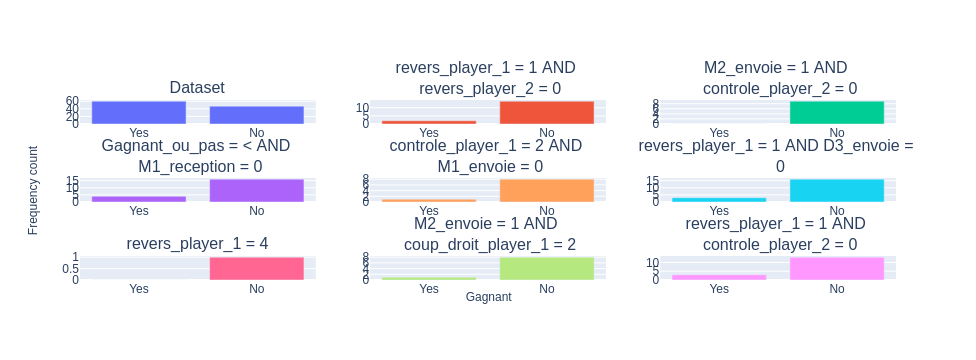

In [10]:
target_columns = ['Gagnant']
clf = emm.EMM(width=10, depth=2, evaluation_metric='distribution_cosine')
clf.search(ft_data, target_cols=target_columns)
clf.visualise(subgroups=8, cols=3)

#### En cas d'absence des plots (raison inconnue) les voir au lien suivant : https://drive.google.com/drive/folders/1-dbeIrw8IB_7k0rzqxPlRlqS412ePRaw?usp=sharing


Sur __107__ points joués, le joueur __F__ en gagne __60__.

1. Si __F__ joue de revers et que l'adversaire ne répond pas avec un revers, il a très peu de chances de remporter le point (14 points perdus sur 16);
2. Si pendant le point, __F__ joue sur la zone __M2__ et que l'adversaire pendant le même point ne joue jamais des coup de type "contrôle", le jouer __F__ n'a pas de chance de remporter le point (9 points perdus sur 9);
3. Si __F__ est en train de perdre le set et qu'il ne reçoit jamais la balle en __M1__, il a peu de chances de remporter le point (16 points perdus sur 20);
4. Si __F__ joue un coup de type "contrôle" deux fois mais qu'il envoie jamais sur __M1__, il a peu de chances de remporter le point (8 points perdus sur 9);
5. Si pendant le point __F__ joue un coup de "revers" mais qu'il envoie jamais sur __D3__, il a peu de chances de remporter le point (16 points perdus sur 19);


#### <u>Pour le joueur B.T.</u>

In [11]:
bt_data = df_player("B", data)

In [12]:
bt_data

,Duree,coup_droit_player_1,coup_droit_player_2,revers_player_1,revers_player_2,Nb_coups,Set,Gagnant_ou_pas,Service,controle_player_1,...,D2_reception,D3_envoie,D3_reception,G1_envoie,G1_reception,G2_envoie,G2_reception,G3_envoie,G3_reception,Gagnant
0,long,1,1,2,3,8,1,>,player2 - Latéral droit,2,...,0,0,0,0,0,0,0,1,1,Yes
1,short,2,2,0,1,5,1,>,player2 - Latéral droit,1,...,0,1,0,0,0,0,0,1,0,Yes
2,middle,3,0,0,2,5,1,>,player1 - Latéral gauche,1,...,0,0,0,0,0,0,0,1,1,No
3,middle,1,1,1,0,3,1,=,player1 - Latéral droit,1,...,1,0,0,0,0,0,0,0,0,No
4,short,1,1,0,1,3,1,>,player2 - Latéral droit,0,...,0,0,0,0,0,0,0,1,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,middle,0,1,2,1,4,5,<,player2 - Latéral droit,0,...,0,0,1,0,1,0,0,1,0,No
103,middle,1,2,1,0,4,5,<,player1 - Latéral droit,0,...,0,1,0,0,0,0,0,0,0,Yes
104,middle,3,1,0,1,5,5,<,player1 - Latéral droit,0,...,1,0,0,0,0,0,0,0,0,Yes
105,middle,1,2,0,1,4,5,<,player2 - Latéral droit,0,...,0,0,0,0,0,0,0,1,0,Yes


In [14]:
target_columns = ['Gagnant']
clf = emm.EMM(width=10, depth=2, evaluation_metric='distribution_cosine')
clf.search(bt_data, target_cols=target_columns)
clf.visualise(subgroups=8, cols=3)

#### En cas d'absence des plots (raison inconnue) les voir au lien suivant : https://drive.google.com/drive/folders/1-dbeIrw8IB_7k0rzqxPlRlqS412ePRaw?usp=sharing


Le joueur __B__ a gagné __46__ points sur __107__ joués.

1. Si l'adversaire a joué un coup de revers et que __B__ ne joue aucun coup de revers, __B__ a des fortes chances de gagner le point (14 points gagnés sur 16);
2. Si __B__ reçoie sur __M2__ une fois lors du point et qu'il effectue jamais un coup de type "contrôle", il a des fortes chances de gagner le point (9 points gagnés sur 9);
3. Si __B__ est en train de gagner le set et que il envoie jamais sur __M1__, il a des fortes chances de gagner le point (16 points gagnés sur 20);
4. Si l'adversaire joue une fois de revers et qu'il envoie jamais sur __D3__ pendant le point, __B__ a des fortes chances de gagner le point (16 points gagnés sur 19);
5. Si pendant un point l'adversaire joue un seul coup de revers et que __B__ ne joue jamais avec un coup de type "poussette",le joueur __B__ a des bonnes chances de remporter le point (21 points gagnés sur 29);


#### Considérations sur l'algoritmhe _EMM_

D'un point de vue technique, l'implémentation n'est pas facile, le package étant pauvre en documentation. Pour en comprendre certains aspects, nous avons dû aller regarder le code source, notamment pour savoir le nombre de targets nécessaire par chaque métrique (important pour appliquer une stratégie plutôt qu'une autre) ou encore le type que les colonnes sont censées avoir (type: <u>object</u>).

En dehors de ça, on peut vraiment remarquer que, comme l'algorithme fait une _recherche excpetionnelle de motifs_; pour le joueur __F__ il nous propose uniquement des motifs dans lesquels il perd des points, alors qu'on sait _a priori_ qu'il est le joueur qui a remporté le plus de points et qui a gagné la partie. Viceversa, en considérant le joueur __B__, il nous retourne que des motifs pour lesquels il gagne des points.

La métrique utilisée, _distribution cosine_ permet d'évaluer la similarité d'objets en regardant leur taille.

## 3 Analyse des points gagné par les joueurs B et F séparemment, avec Pysubgroup.

## Chargement des données :


In [16]:
import pandas as pd
import numpy as np
import pysubgroup as ps

In [24]:
data = pd.read_csv("TT_game.csv", sep = ",")
data.head()

,Nom,Position,Durée,Genre,Latéralité,Set,Système,Coup,Nbre de coups par point,Durée du point,Score,Points F,Points B,Type de service,Type Coup TK,Zone de jeu
0,SET (1),0:00:00.000,0:00:00.000,Garçons,Droitier/gaucher,1,Att/att,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F.T. (1),0:00:00.000,0:00:00.000,Garçons,Coup droit,SET,Att/att,F.T.,NaN,NaN,NaN,NaN,NaN,Latéral droit,NaN,NaN
2,B.T. (1),0:00:00.266,0:00:00.417,Garçons,Revers,SET,Att/att,B.T.,NaN,NaN,NaN,NaN,NaN,NaN,Controle / Résistance,M2
3,F.T. (2),0:00:00.684,0:00:00.350,Garçons,Revers,SET,Att/att,F.T.,NaN,NaN,NaN,NaN,NaN,NaN,Attaque / Offensif,M3
4,B.T. (2),0:00:01.034,0:00:00.333,Garçons,Revers,SET,Att/att,B.T.,NaN,NaN,NaN,NaN,NaN,NaN,Controle / Résistance,M3


In [25]:
### On enlève les colonnes qui sont inutiles car ayant la même valeur pour tous les coups : Genre et système

data = data.drop(columns = ["Genre", "Système"])

### On met le numéro du set dans toutes les lignes :

for index, row in data.iterrows():
    val = row["Nom"]
    if val.startswith("SET"):
        set_nb = val.split("(")[1][:1]
    data.at[index, "Set"] = set_nb

### On complète les cases vides pour les types de services, de coup, et les zones de jeu :

data.loc[data["Type de service"].isnull(), "Type de service"] = "non"
data.loc[data["Type Coup TK"].isnull(), "Type Coup TK"] = "service"
data.loc[data["Zone de jeu"].isnull(), "Zone de jeu"] = "aucune"

### On complète les données des scores individuels des joueurs :¶

Na_or_Not = data["Points B"].isna()
set_nb = 0
for index in range(data.shape[0]):
    if Na_or_Not[index] :
        data.at[index, "Points B"] = set_nb
    else : 
        set_nb = data.at[index, "Points B"]
        
Na_or_Not = data["Points F"].isna()
set_nb = 0
for index in range(data.shape[0]):
    if Na_or_Not[index] :
        data.at[index, "Points F"] = set_nb
    else : 
        set_nb = data.at[index, "Points F"]
        
### On encode les valeurs de scores :¶
        
Na_or_Not = data["Score"].isna()
set_score = "0 - 0"
for index in range(data.shape[0]):
    if Na_or_Not[index] :
        data.at[index, "Score"] = set_score
    else : 
        set_score = f"{data['Points F'][index]} - {data['Points B'][index]}"
        
### On compte les coups des échanges :

c = 0
for index, row in data.iterrows():
    if (row["Coup"] != "F.T.") and (row["Coup"] != "B.T."):
        c = 0
        data.at[index, "Nbre de coups par point"] = c
    else:
        c += 1
        data.at[index, "Nbre de coups par point"] = c
data["Nbre de coups par point"] = pd.to_numeric(data["Nbre de coups par point"]).astype(int) 

### Correction des valeurs temporelles :

data['Position'] = pd.to_timedelta(data['Position'])
data['Durée'] = pd.to_timedelta(data['Durée'])
data['Durée du point'] = pd.to_timedelta(data['Durée du point'])

data["Position"] = (data["Position"] / np.timedelta64(10**9,'ns')).astype(float)
data["Durée"] = (data["Durée"] / np.timedelta64(10**9,'ns')).astype(float)
data.drop(columns = ["Durée du point"])
data.head()

### On enlève les SET (X) qui sont inintéressant car ne sont pas des coups : 

data.replace(to_replace = r"^SET.*$", value = "nan", inplace = True, regex = True)
rem = []
for index, row in data.iterrows() :
    if row["Nom"] == "nan" :
        rem.append(index)

data.drop(index = rem, axis = 0, inplace = True)
data.reset_index(inplace = True, drop = True)

### On enlève encode la victoire ou défaite de chaque joueur par des 1 et 0 respectivements pour tous les sets :

victory_F = []
victory_B = []
iter_cond = ["Serveur Point -", "Serveur Point +"]

for index, row in data.iterrows():
    if row["Type Coup TK"] == "service" :
        service = row["Nom"]
    if row["Coup"] in iter_cond :
        if service.startswith("F") and row["Coup"] == "Serveur Point +":
            victory_F += np.repeat(1, data.at[index-1, "Nbre de coups par point"] + 1).tolist()
            victory_B += np.repeat(0, data.at[index-1, "Nbre de coups par point"] + 1).tolist()
        elif service.startswith("B") and row["Coup"] == "Serveur Point -":
            victory_F += np.repeat(1, data.at[index-1, "Nbre de coups par point"] + 1).tolist()
            victory_B += np.repeat(0, data.at[index-1, "Nbre de coups par point"] + 1).tolist()
        else :
            victory_F += np.repeat(0, data.at[index-1, "Nbre de coups par point"] + 1).tolist()
            victory_B += np.repeat(1, data.at[index-1, "Nbre de coups par point"] + 1).tolist()
            
data["Victory F"] = victory_F
data["Victory B"] = victory_B

df = data

df.drop(columns = ["Nom", "Durée", "Position", "Durée du point", "Set"], inplace = True)

In [26]:
df.head()

,Latéralité,Coup,Nbre de coups par point,Score,Points F,Points B,Type de service,Type Coup TK,Zone de jeu,Victory F,Victory B
0,Coup droit,F.T.,1,0 - 0,0.0,0.0,Latéral droit,service,aucune,0,1
1,Revers,B.T.,2,0 - 0,0.0,0.0,non,Controle / Résistance,M2,0,1
2,Revers,F.T.,3,0 - 0,0.0,0.0,non,Attaque / Offensif,M3,0,1
3,Revers,B.T.,4,0 - 0,0.0,0.0,non,Controle / Résistance,M3,0,1
4,Revers,F.T.,5,0 - 0,0.0,0.0,non,Attaque / Offensif,M3,0,1


In [27]:
df.to_csv("data.txt", sep = " ", index = False) ### tentative d'utiliser PrefixSpan, mais docu absente, pas de commentaire de code

Notes sur le jeu de données : il n'y a pas de zone de jeu pour le service jusque ligne 171 (avec index commançant à 0). Chaque joueur sert 2 fois d'affilées qu'il ait gagné le point ou non. La colonne Nom indique le nom du joueur et le numéro de son coup dans la partie : ce numéro se décale au fur et à mesure au fil des services et coups gagnants. 

#### On analyse les stratégies individuelles des joueurs pour gagner un point :

In [28]:
data.head()

,Latéralité,Coup,Nbre de coups par point,Score,Points F,Points B,Type de service,Type Coup TK,Zone de jeu,Victory F,Victory B
0,Coup droit,F.T.,1,0 - 0,0.0,0.0,Latéral droit,service,aucune,0,1
1,Revers,B.T.,2,0 - 0,0.0,0.0,non,Controle / Résistance,M2,0,1
2,Revers,F.T.,3,0 - 0,0.0,0.0,non,Attaque / Offensif,M3,0,1
3,Revers,B.T.,4,0 - 0,0.0,0.0,non,Controle / Résistance,M3,0,1
4,Revers,F.T.,5,0 - 0,0.0,0.0,non,Attaque / Offensif,M3,0,1


In [35]:
target = ps.BinaryTarget('Victory F', True)
searchspace = ps.create_selectors(data, ignore=['Victory B', 'Victory F', 'Coup'])
task = ps.SubgroupDiscoveryTask(
    data, 
    target, 
    searchspace, 
    result_set_size=10, 
    depth=3, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

result.to_dataframe()[["quality", "subgroup"]]

,quality,subgroup
0,0.037033,Points F: [5.0:9.0[
1,0.025571,Latéralité=='Coup droit' AND Points F: [5.0:9.0[
2,0.022566,Points B: [4.0:5.0[
3,0.022200,Points B: [2.0:4.0[
4,0.022053,Latéralité=='Coup droit' AND Nbre de coups par...
5,0.021702,Points B: [5.0:9.0[ AND Points F: [5.0:9.0[
6,0.021695,Type de service=='non' AND Zone de jeu=='M1'
7,0.021521,Nbre de coups par point: [1:3[ AND Points F: [...
8,0.020801,Points F: [5.0:9.0[ AND Type de service=='non'
9,0.019399,Zone de jeu=='M1'


Il semble que le joueur F gagne les sets quand il a entre 5 et 9 points. F favorise les coups droits. On trouve aussi 2 fois la mention du nombre de coups entre 1 et 3 : il semble que le joueur F gagne plus souvent lorsque les points sont rapides. Le fait que F gagne quand il ne sert pas revient aussi 2 fois.

In [36]:
target = ps.BinaryTarget('Victory B', True)
searchspace = ps.create_selectors(data, ignore=['Victory B', 'Victory F', 'Coup'])
task = ps.SubgroupDiscoveryTask(
    data, 
    target, 
    searchspace, 
    result_set_size=10, 
    depth=3, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

result.to_dataframe()[["quality", "subgroup"]]

,quality,subgroup
0,0.029858,Points F: [9.0:10.0[
1,0.025620,Latéralité=='Coup droit' AND Type Coup TK=='Co...
2,0.025620,Latéralité=='Coup droit' AND Type Coup TK=='Co...
3,0.022792,Points F: [9.0:10.0[ AND Type de service=='non'
4,0.022781,Points B<2.0 AND Points F: [3.0:5.0[
5,0.022611,Latéralité=='Coup droit' AND Points F: [9.0:10.0[
6,0.019248,Points B>=9.0 AND Points F: [9.0:10.0[
7,0.018543,Points B<2.0 AND Points F: [3.0:5.0[ AND Type ...
8,0.018366,Latéralité=='Coup droit' AND Points B<2.0 AND ...
9,0.018011,Score=='3.0 - 1.0'


Le joueur B gagne quand F est à 9 points, et lorsque F est entre 3 et 5 points. Il favorise les coups droits et a visiblement un préférence pour les coups de contrôle plutôt que pour les coups agressifs.

En joignant les informations, on peut supposer que F joue plus agressivement, gagnant les points entre le 5ème et le 9ème. Au contraire, B gagne plus en début de set, et lorsque F atteint les 10 points, soit les 2/3, fin du set. Les deux joueurs utilisent les coups droits. Concernant le nombre de coups par points, F gagne lorsque les échangent sont cours (ce qui correspond a une stratégie agressive) et B gagne lorsque les échanges durent, ce qui correspond à un stratégie de contrôle. Les zones de jeux ne font qu'une seule apparition dans les tableaux, il faudra donc ignorer plus de colonnes pour trouver des informations à ce sujet : cependant, n'étant pas apparues avant, l'information qu'on en tirerait serait probablement moins fiable/intéressante.

## 4 Analyse des séquences de jeu par joueur gagnant un point avec mlxtend

#### Import des librairies

In [23]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#### Import du jeu de données

In [2]:
data = pd.read_csv('TT_game.csv',sep=';')

#### Définition des séquences de jeu par point
Pour chaque point on enregistre le premier et le dernier échange dans seq

In [4]:
seq = []
seq.append(0)
for i in range(522):
    if data["Coup"][i]=='Serveur Point -'or data["Coup"][i]=='Serveur Point +':
        seq.append(i)
#seq

#### On crée une liste d'échanges par joueur qui a gagné le point
Le jouer qui gagne un point est celui qui sert et avec Serveur Point + ou celui qui ne sert pas et avec Serveur Point -

In [5]:
echangeB = []
echangeF = []
for i in range(len(seq)-1):
    if data["Coup"][seq[i+1]] == 'Serveur Point -' and data["Coup"][seq[i]+1]=='F.T.':
        echangeB.append(data.iloc[seq[i]+1:(seq[i+1]+1)])
    elif data["Coup"][seq[i+1]] == 'Serveur Point +' and data["Coup"][seq[i]+1]=='B.T.':
        echangeB.append(data.iloc[seq[i]+1:(seq[i+1]+1)])
    elif data["Coup"][seq[i+1]] == 'Serveur Point +' and data["Coup"][seq[i]+1]=='F.T.':
        echangeF.append(data.iloc[seq[i]+1:(seq[i+1]+1)])
    elif data["Coup"][seq[i+1]] == 'Serveur Point -' and data["Coup"][seq[i]+1]=='B.T.':
        echangeF.append(data.iloc[seq[i]+1:(seq[i+1]+1)])


Parmi les échanges qui ont amené le joueur B à gagner le point, on extrait les coups du joueur B.

In [7]:
lstCoupB = []
for i in range(len(echangeB)):
    lstCoupB.append(echangeB[i][echangeB[i]['Nom'].str.startswith('B.T.')])

Parmi les échanges qui ont amené le joueur F à gagner le point, on extrait les coups du joueur F.

In [9]:
lstCoupF = []
for i in range(len(echangeF)):
    lstCoupF.append(echangeF[i][echangeF[i]['Nom'].str.startswith('F.T.')])

On extrait les zones de jeu par point gagné du joueur B.

In [13]:
lstZoneB = []
for i in range(len(lstCoupB)):
    lstZoneB.append(list(lstCoupB[i]['Zone de jeu'].dropna()))

On extrait les zones de jeu par point gagné du joueur F.

In [14]:
lstZoneF = []
for i in range(len(lstCoupF)):
    lstZoneF.append(list(lstCoupF[i]['Zone de jeu'].dropna()))

On extrait les latéralités par point gagné du joueur B.

In [15]:
lstLateraliteB = []
for i in range(len(lstCoupB)):
    lstLateraliteB.append(list(lstCoupB[i]['Latéralité'].dropna()))

On extrait les latéralités par point gagné du joueur F.

In [16]:
lstLateraliteF = []
for i in range(len(lstCoupF)):
    lstLateraliteF.append(list(lstCoupF[i]['Latéralité'].dropna()))

On extrait les types de coup par point gagné du joueur B.

In [18]:
lstAttaqueB = []
for i in range(len(lstCoupB)):
    lstAttaqueB.append(list(lstCoupB[i]['Type Coup TK'].dropna()))

On extrait les types de coup par point gagné du joueur F.

In [19]:
lstAttaqueF = []
for i in range(len(lstCoupF)):
    lstAttaqueF.append(list(lstCoupF[i]['Type Coup TK'].dropna()))

### Utilisation de mlxtend pour connaître les zones de jeu du joueur B avec les supports maximaux

In [22]:
te = TransactionEncoder()
te_ary = te.fit(lstZoneB).transform(lstZoneB)
df = pd.DataFrame(te_ary, columns=te.columns_)
freq_item = apriori(df,0.1,use_colnames=True)
freq_item.sort_values('support',ascending = False,inplace=True)
freq_item

,support,itemsets
4,0.409091,(M3)
1,0.386364,(G3)
0,0.318182,(D3)
2,0.159091,(M1)
3,0.159091,(M2)
5,0.159091,"(D3, M3)"
6,0.113636,"(G3, M3)"


On voit que les zones M3, G3 et D3 sont privilégiées pour la stratégie du joueur B lorsqu'il gagne un point.

#### Règles d'association pour les zones de jeu du joueur B

In [25]:
association_rules(freq_item, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(D3),(M3),0.318182,0.409091,0.159091,0.500000,1.222222,0.028926,1.181818
1,(M3),(D3),0.409091,0.318182,0.159091,0.388889,1.222222,0.028926,1.115702
2,(G3),(M3),0.386364,0.409091,0.113636,0.294118,0.718954,-0.044421,0.837121
3,(M3),(G3),0.409091,0.386364,0.113636,0.277778,0.718954,-0.044421,0.849650


On voit que les enchainements des zones de jeu D3->M3, M3->D3, G3->M3 et M3->G3 sont privilégiés par le joueur B lorsqu'il gagne un point.

## Utilisation de mlxtend pour connaître les zones de jeu du joueur F avec les supports maximaux

In [27]:
te = TransactionEncoder()
te_ary = te.fit(lstZoneF).transform(lstZoneF)
df = pd.DataFrame(te_ary, columns=te.columns_)
freq_item = apriori(df,0.1,use_colnames=True)
freq_item.sort_values('support',ascending = False,inplace=True)
freq_item

,support,itemsets
2,0.431034,(M1)
4,0.362069,(M3)
0,0.310345,(D3)
1,0.189655,(G3)
7,0.172414,"(M3, M1)"
5,0.137931,"(D3, M1)"
6,0.120690,"(D3, M3)"
3,0.103448,(M2)


On voit que les zones M1, M3 et D3 sont privilégiées pour la stratégie du joueur F lorsqu'il gagne un point.

#### Règles d'association pour les zones de jeu du joueur F

In [28]:
association_rules(freq_item, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(M3),(M1),0.362069,0.431034,0.172414,0.476190,1.104762,0.016350,1.086207
1,(M1),(M3),0.431034,0.362069,0.172414,0.400000,1.104762,0.016350,1.063218
2,(D3),(M1),0.310345,0.431034,0.137931,0.444444,1.031111,0.004162,1.024138
3,(M1),(D3),0.431034,0.310345,0.137931,0.320000,1.031111,0.004162,1.014199
4,(D3),(M3),0.310345,0.362069,0.120690,0.388889,1.074074,0.008323,1.043887
5,(M3),(D3),0.362069,0.310345,0.120690,0.333333,1.074074,0.008323,1.034483


On voit que les enchainements des zones de jeu M3->M1, M1->M3, D3->M1, M1->D3, D3->M3 et M3->D3 sont privilégiés par le joueur F lorsqu'il gagne un point.

### Utilisation de mlxtend pour connaître les types de coup du joueur B avec les supports maximaux

In [29]:
te = TransactionEncoder()
te_ary = te.fit(lstAttaqueB).transform(lstAttaqueB)
df = pd.DataFrame(te_ary, columns=te.columns_)
freq_item = apriori(df,0.1,use_colnames=True)
freq_item.sort_values('support',ascending = False,inplace=True)
freq_item

,support,itemsets
0,0.500000,(Attaque / Offensif)
1,0.454545,(Controle / Résistance)
2,0.250000,(Poussette)
3,0.159091,"(Controle / Résistance, Attaque / Offensif)"


Le joueur B joue plus fréquemment l'attaque et le contrôle lorsqu'il gagne un point.

#### Règles d'association pour les types de coup du joueur B

In [30]:
association_rules(freq_item, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Controle / Résistance),(Attaque / Offensif),0.454545,0.500000,0.159091,0.350000,0.7,-0.068182,0.769231
1,(Attaque / Offensif),(Controle / Résistance),0.500000,0.454545,0.159091,0.318182,0.7,-0.068182,0.800000


Le joueur B aura tendance à faire des enchaînements Contrôle->Attaque, Attaque->Contrôle lorsqu'il gagne un point.

### Utilisation de mlxtend pour connaître les types de coup du joueur F avec les supports maximaux

In [31]:
te = TransactionEncoder()
te_ary = te.fit(lstAttaqueF).transform(lstAttaqueF)
df = pd.DataFrame(te_ary, columns=te.columns_)
freq_item = apriori(df,0.1,use_colnames=True)
freq_item.sort_values('support',ascending = False,inplace=True)
freq_item

,support,itemsets
0,0.534483,(Attaque / Offensif)
2,0.327586,(Poussette)
1,0.293103,(Controle / Résistance)
4,0.172414,"(Poussette, Attaque / Offensif)"
3,0.137931,"(Controle / Résistance, Attaque / Offensif)"
5,0.103448,"(Poussette, Controle / Résistance)"


Le joueur F joue plus l'attaque et la poussette lorsqu'il gagne un point.

#### Règles d'association pour les types de coup du joueur F

In [32]:
association_rules(freq_item, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Poussette),(Attaque / Offensif),0.327586,0.534483,0.172414,0.526316,0.984720,-0.002675,0.982759
1,(Attaque / Offensif),(Poussette),0.534483,0.327586,0.172414,0.322581,0.984720,-0.002675,0.992611
2,(Controle / Résistance),(Attaque / Offensif),0.293103,0.534483,0.137931,0.470588,0.880455,-0.018728,0.879310
3,(Attaque / Offensif),(Controle / Résistance),0.534483,0.293103,0.137931,0.258065,0.880455,-0.018728,0.952774
4,(Poussette),(Controle / Résistance),0.327586,0.293103,0.103448,0.315789,1.077399,0.007432,1.033156
5,(Controle / Résistance),(Poussette),0.293103,0.327586,0.103448,0.352941,1.077399,0.007432,1.039185


Le joueur F aura plus tendance à faire des enchainements Poussette->Attaque, Attaque->Poussette lorsqu'il gagne un point.

### Utilisation de mlxtend pour connaître les latéralités du joueur B avec les supports maximaux

In [34]:
te = TransactionEncoder()
te_ary = te.fit(lstLateraliteB).transform(lstLateraliteB)
df = pd.DataFrame(te_ary, columns=te.columns_)
freq_item = apriori(df,0.1,use_colnames=True)
freq_item.sort_values('support',ascending = False,inplace=True)
freq_item

,support,itemsets
0,0.909091,(Coup droit)
1,0.477273,(Revers)
2,0.386364,"(Revers, Coup droit)"


Le joueur B gagne les points en se servant majoritairement du coup droit.

#### Règles d'association pour les latéralités du joueur B

In [35]:
association_rules(freq_item, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Revers),(Coup droit),0.477273,0.909091,0.386364,0.809524,0.890476,-0.047521,0.477273
1,(Coup droit),(Revers),0.909091,0.477273,0.386364,0.425000,0.890476,-0.047521,0.909091


### Utilisation de mlxtend pour connaître les latéralités du joueur F avec les supports maximaux

In [36]:
te = TransactionEncoder()
te_ary = te.fit(lstLateraliteF).transform(lstLateraliteF)
df = pd.DataFrame(te_ary, columns=te.columns_)
freq_item = apriori(df,0.1,use_colnames=True)
freq_item.sort_values('support',ascending = False,inplace=True)
freq_item

,support,itemsets
0,0.913793,(Coup droit)
1,0.396552,(Revers)
2,0.310345,"(Revers, Coup droit)"


Le joueur F gagne les points en se servant majoritairement du coup droit.

#### Règles d'association pour les latéralités du joueur F

In [37]:
association_rules(freq_item, metric="confidence", min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Revers),(Coup droit),0.396552,0.913793,0.310345,0.782609,0.85644,-0.052021,0.396552
1,(Coup droit),(Revers),0.913793,0.396552,0.310345,0.339623,0.85644,-0.052021,0.913793


## Conclusion :

A propos du service : les coups latéraux droits en M1 sont les plus efficaces en service, et généralement les services en M1 et G3 sont propices à la victoire du point. On peut dire que les stratégies des joueurs diffèrent pour marquer le point. Le joueur B aura tendance à jouer sur M3 tandis que le joueur F jouera sur M1. Le joueur B utilise plus le contrôle/résistance pour des échanges de plus de 4 coups alors que le joueur F utilise plus la poussette et gagne des échanges courts. Concernant les zones de jeu : le joueur B joue plutôt ses balles au fond de la table pour gagner (les zones 3) alors que le joueur F utilise des motifs de transition entre zones du fond et du milieu de la table (des zones 1 à 3 et 3 à 1 : correspond à l'utilisation de la poussette). Les 2 joueurs jouent des coups droits de préférence. B gagne plutôt ses points lorsqu'il en a peu, et lorsque le joueur F est arrivé à 10 points. Au contraire, le joueur F gagne quand les 2 joueurs sont entre 5 et 9 point. EMM nous apprend aussi des tendances, qui sont symétriques entre le joueur F et B, mais elles ne sont pas extrapolables en stratégies car trop précises.

De façon générale, le joueur F joue aggressivement, avec des échanges courts, en changeant ses zones de jeu alternativement entre 1 et 3, et gagnant ses points en milieu de set. Le joueur B lui utilise une stratégie de contrôle, sur des échanges longs, en jouant au fond de la table (zones 3). Les services au filet et à l'extrême gauche sont les meilleurs. Les 2 joueurs favorisent les mêmes types de coups.